# Partitionierung

Die Partitionierung von Datensätzen ist eine zentrale Operation um die Berechnungen und Daten verteilen zu können.

Dabei partitioniert Dask einen DataFrame in verschiedene Pandas DataFrames:

<img src="assets/dask-dataframe.svg" style="max-height: 200px;" />

## Räumliche Partitionierung

Mit räumlichen Daten kann die Partionierung nicht einfach vertikal geschehen. In der Regel werden ja räumliche Operationen durchgeführt, und dabei müssen alle Daten für die Region auf dem Knoten vorhanden sein. Deshalb ist es in der Regel sinnvoll, die Partionierung räumlich vorzunehmen.

Die Bibliothek `dask-geopandas` organisiert GeoPandas-DataFrames in räumliche Regionen. Die Daten für jede Region können dann separat von einem anderen Thread oder auf einem anderen Rechner verarbeitet werden.

Allerdings können wir auch ohne räumliche Partitionierung die Berechnungen parallel oder verteilt vornehmen. Im vorherigen Beispiel 

Für raumbezogene Operationen wie Spatial Joins können mit einer räumlichen Partition nur jene DataFrames einbezogen werden, die für die Berechnung relevant sind.

### Räumliche Partitionierung mit Dask-GeoPandas

Schauen wir nun konkret, wie Dask-GeoPandas die räumliche Struktur der Daten zur Partitionierung verwenden kann.

Laden wir erst die benötigten Bibliotheken:

In [1]:
import fiona
import geopandas
import dask_geopandas
import matplotlib.pyplot as plt

Laden wir alle Kantone in ein GeoPandas-DataFrame. Dabei verwenden wir einen Datensatz von Swisstopo:

In [ ]:
swiss_boundaries_3d = '../data/swissBoundaries3D_202201/swissBoundaries3D_1_3_TLM.gpkg'
fiona.listlayers(swiss_boundaries_3d)

In [5]:
cantons = geopandas.read_file(swiss_boundaries_3d, layer='Kantonsgebiet')
cantons.head()

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,OBJEKTART,REVISION_Q,ICC,KANTONSNUM,SEE_FLAECH,KANTONSFLA,KT_TEIL,NAME,EINWOHNERZ,geometry
0,{0B2364ED-49E0-4D53-A33C-C684DD530B57},2018-11-22,2012-10-26,2012,10,2022,1,Verbessert,AV,2019,...,Kanton,2021_Aufbau,CH,18,NaN,710530.0,0,Graubünden,200096.0,"POLYGON Z ((2735215.665 1194955.161 2870.714, ..."
1,{DDD56CEF-0E61-4EED-85ED-F67A459C93ED},2021-11-02,2012-10-26,2012,10,2022,1,Verbessert,AV,2021,...,Kanton,2021_Aufbau,CH,2,11897.0,595850.0,1,Bern,1043081.0,"POLYGON Z ((2595241.510 1169313.282 2090.846, ..."
2,{54B25E50-30A7-4995-ADE3-5FFF6E13A995},2018-11-22,2012-10-26,2012,10,2022,1,Verbessert,AV,2019,...,Kanton,2021_Aufbau,CH,23,1060.0,522463.0,0,Valais,348503.0,"POLYGON Z ((2601807.628 1136116.777 2948.413, ..."
3,{921DFEF2-6D91-4CB8-9CFC-2A831C412020},2019-11-06,2012-10-26,2012,10,2022,1,Verbessert,swisstopo,2019,...,Kanton,2021_Aufbau,CH,22,39097.0,321202.0,1,Vaud,814762.0,"POLYGON Z ((2555092.813 1138713.419 372.133, 2..."
4,{95F10F52-8B2F-4D6A-AF7E-D4F915E42F89},2020-11-19,2012-10-26,2012,10,2022,1,Verbessert,AV,2020,...,Kanton,2021_Aufbau,CH,21,7147.0,281215.0,0,Ticino,350986.0,"POLYGON Z ((2727358.511 1119219.094 1351.527, ..."


Gewisse Kantone haben mehrere Teile, auf mehrere Zeilen verteilt. Für unsere Zwecke ist das ok.

In [6]:
cantons.shape

(50, 21)

Wir können noch ein paar Infos anzeigen und eine Karte machen:

In [7]:
cantons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UUID        50 non-null     object  
 1   DATUM_AEND  50 non-null     object  
 2   DATUM_ERST  50 non-null     object  
 3   ERSTELL_J   50 non-null     int64   
 4   ERSTELL_M   50 non-null     object  
 5   REVISION_J  50 non-null     int64   
 6   REVISION_M  50 non-null     object  
 7   GRUND_AEND  50 non-null     object  
 8   HERKUNFT    50 non-null     object  
 9   HERKUNFT_J  50 non-null     int64   
 10  HERKUNFT_M  50 non-null     object  
 11  OBJEKTART   50 non-null     object  
 12  REVISION_Q  50 non-null     object  
 13  ICC         50 non-null     object  
 14  KANTONSNUM  50 non-null     int64   
 15  SEE_FLAECH  19 non-null     float64 
 16  KANTONSFLA  26 non-null     float64 
 17  KT_TEIL     50 non-null     object  
 18  NAME        50 non-null     object  
 19  EI

<AxesSubplot: >

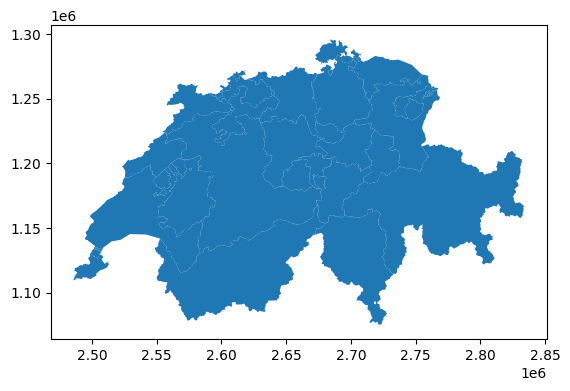

In [8]:
cantons.plot()

Bisher haben wir mit GeoPandas gearbeitet. Wir können das DataFrame in eine Dask-GeoPandas-DataFrame umwandeln. Wir legen dabei fest, dass wir 4 Partitionen wollen:

In [10]:
cantons_d = dask_geopandas.from_geopandas(cantons, npartitions = 4)
cantons_d

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,HERKUNFT_M,OBJEKTART,REVISION_Q,ICC,KANTONSNUM,SEE_FLAECH,KANTONSFLA,KT_TEIL,NAME,EINWOHNERZ,geometry
npartitions=4,,,,,,,,,,,,,,,,,,,,,
0,object,object,object,int64,object,int64,object,object,object,int64,object,object,object,object,int64,float64,float64,object,object,float64,geometry
13,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Schauen wir uns mal die räumliche Ausdehnung der Partitionen an. Dies kann durch die Berechnung der Convex Hull geschehen:

In [11]:
cantons_d.calculate_spatial_partitions()
cantons_d.spatial_partitions

0    POLYGON Z ((2722641.310 1075268.136 499.307, 2...
1    POLYGON Z ((2485516.582 1109644.837 340.650, 2...
2    POLYGON Z ((2507109.705 1131720.310 372.119, 2...
3    POLYGON Z ((2502429.723 1132920.500 455.204, 2...
dtype: geometry

Dabei können wir diese Polygone auf einer Karte anzeigen:

<AxesSubplot: >

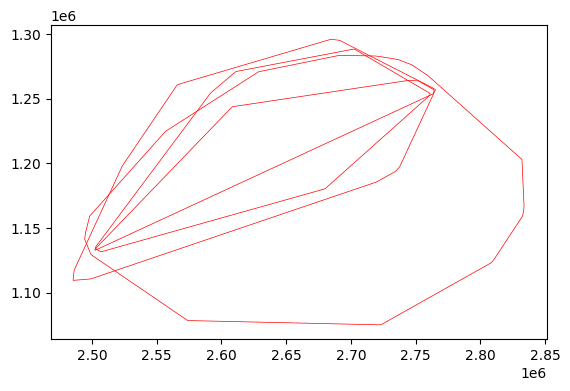

In [13]:
cantons_d.spatial_partitions.plot(facecolor = 'none', linewidth = 0.5, edgecolor = 'red')

oder vielleicht besser so:

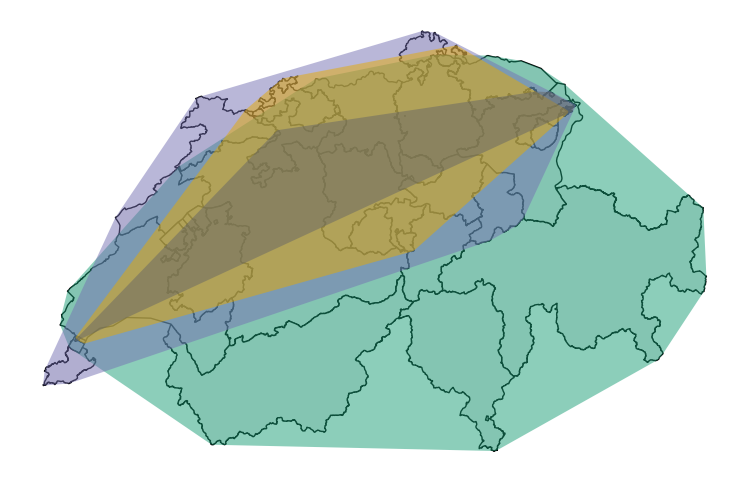

In [25]:
fig, ax = plt.subplots(1,1, figsize = (12,6))
cantons.plot(ax = ax, facecolor = "#eee", linewidth = 1, edgecolor="black")
cantons_d.spatial_partitions.plot(ax = ax, cmap = "Dark2", alpha = 0.5)
ax.set_axis_off()
plt.show()

Die Partitionierung ist nicht gerade optimal. Zur Partitionierung werden die Daten in der Regel sortiert. Also müssen wir die Polygone sortieren, und zwar in 1 Dimension.

Dask-GeoPandas benutzt die Funktion `spatial_shuffle` um die Partitionierung zu definieren. Dabei stehen 3 verschiedene Verfahren zur Verfügung, die relative effizient zweidimensionale Geometrien im eindimensionalen Raum umwandeln können:

- Die Hilbert-Distanz (dies ist die Standard-Methode)
- Die Morton-Distanz
- Ein Geohash

Bei den ersten beiden Methoden handelt es sich um raumfüllende Kurven, d. h. um Linien, die durch jeden Punkt im Raum in einer bestimmten Reihenfolge und nur einmal durch die Punkte verlaufen, so dass jeder Punkt in einem bestimmten Abstand entlang der Kurve liegt.

Im Allgemeinen ist die Hilbert-Distanz zu empfehlen, da die Hilbert-Kurve eine bemerkenswerte mathematische Eigenschaft besitzt, bei der der Abstand zwischen zwei aufeinanderfolgenden Punkten entlang der Kurve immer gleich ist. Dies führt meist zu einer besseren Reihenfolge.

Der Geohash ist eine hierarchische räumliche Datenstruktur, die den Raum in ein regelmässiges Gitter unterteilt.

Schauen wir uns die 3 Partitionierungsmethoden konkret an:

In [26]:
hilbert = cantons_d.spatial_shuffle(by = 'hilbert')
morton = cantons_d.spatial_shuffle(by = 'morton')
geohash = cantons_d.spatial_shuffle(by = 'geohash')

Die räumliche Partitionierung sieht dann so aus:

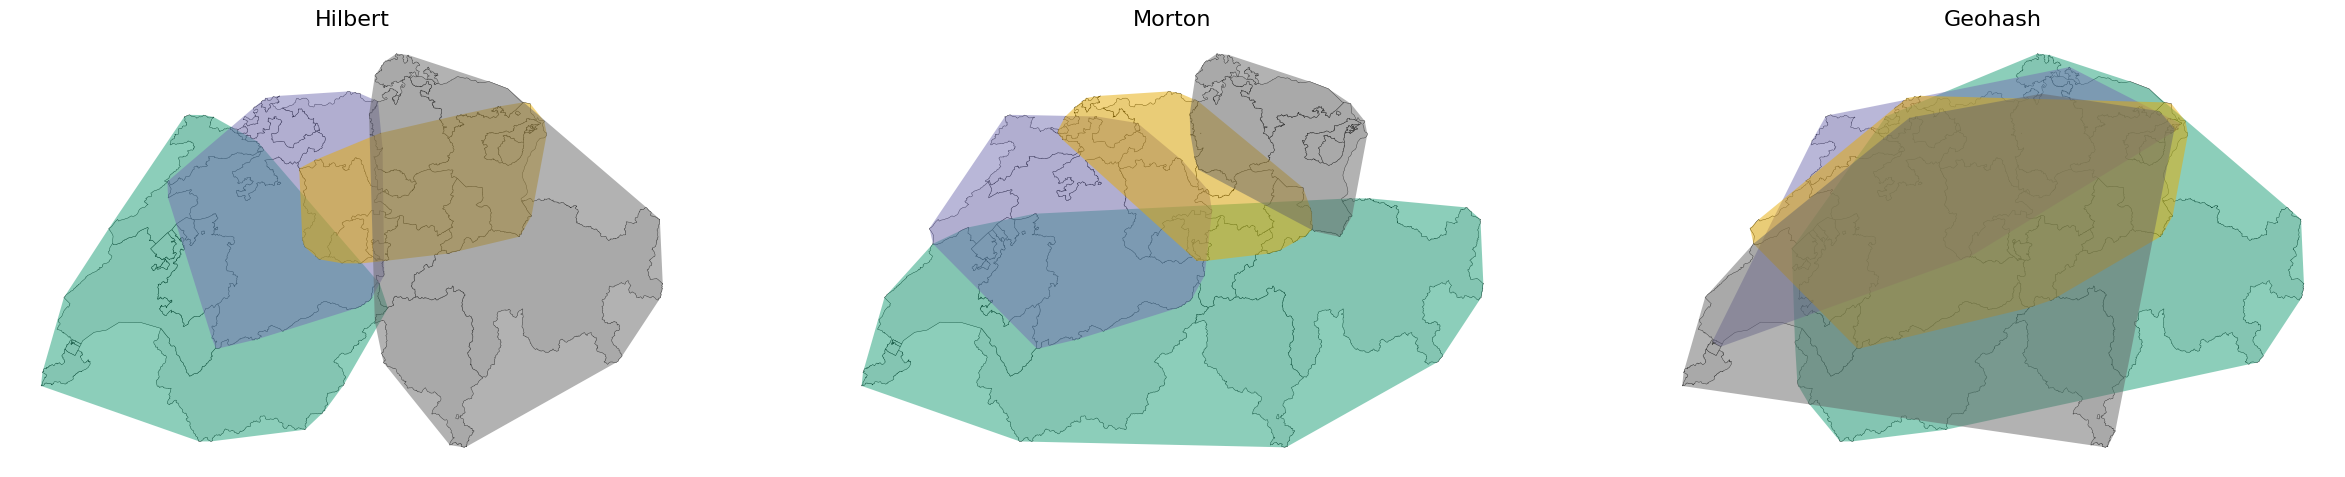

In [28]:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 3,
    figsize = (30, 12)
)
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    cantons.plot(ax = ax, facecolor = "#eee", linewidth = 0.3, edgecolor = "black")

hilbert.spatial_partitions.plot(ax = ax1, cmap = "Dark2", alpha = 0.5)
morton.spatial_partitions.plot(ax = ax2, cmap = "Dark2", alpha = 0.5)
geohash.spatial_partitions.plot(ax = ax3, cmap = "Dark2", alpha = 0.5)

[axi.set_axis_off() for axi in axes.ravel()]

ax1.set_title("Hilbert", size = 16)
ax2.set_title("Morton", size = 16)
ax3.set_title("Geohash", size = 16)

plt.show()

Nicht nur die Partitionierungsmethode, sondern auch die **Anzahl an Partitionen** kann definiert werden. Dies ist durchaus sinnvoll, da dies stark von den Daten abhängig ist. Eine Erhöhung der Anzahl der Partitionen führt zwangsläufig zu einer Verringerung der räumlichen Überschneidung zwischen den Partitionen.

Machen wir einen Vergleich zwischen der original GeoDataFrame ohne räumliche Partitionierung, mit 4 Partitionen und mit 16 Partitionen (jeweils mit der Hilbert-Kurve berechnet).

In [34]:
hilbert16 = cantons_d.spatial_shuffle(
    by = 'hilbert',
    npartitions = 16
)

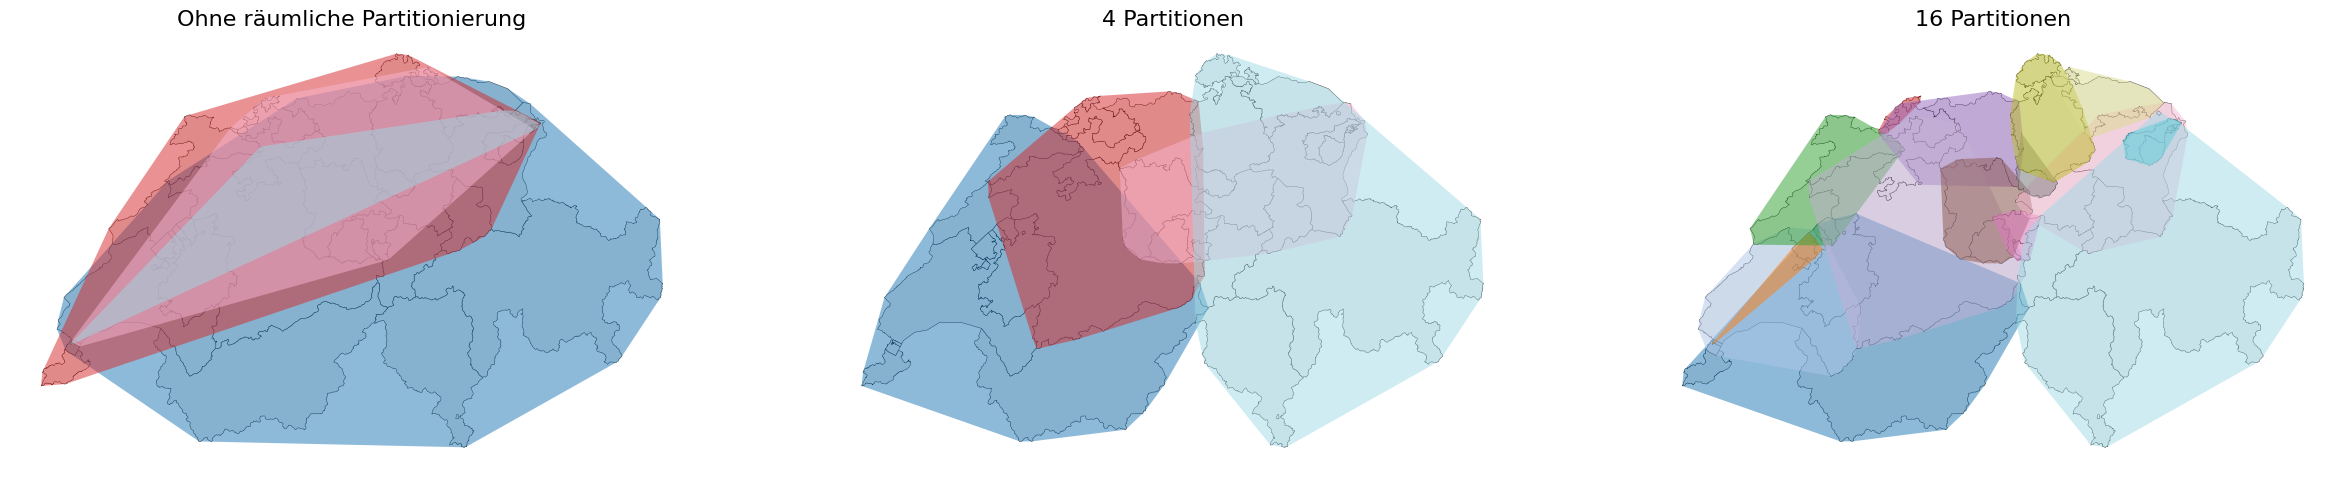

In [31]:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 3,
    figsize = (30, 12)
)
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    cantons.plot(ax = ax, facecolor = "#eee", linewidth = 0.3, edgecolor = "black")

cantons_d.spatial_partitions.plot(ax = ax1, cmap = "tab20", alpha = 0.5)
hilbert.spatial_partitions.plot(ax = ax2, cmap = "tab20", alpha = 0.5)
hilbert16.spatial_partitions.plot(ax = ax3, cmap = "tab20", alpha = 0.5)

[axi.set_axis_off() for axi in axes.ravel()]

ax1.set_title("Ohne räumliche Partitionierung", size = 16)
ax2.set_title("4 Partitionen", size = 16)
ax3.set_title("16 Partitionen", size = 16)

plt.show()

## Dask Best Practices

In der Dask-Dokumentation finden sich einige wertvolle Tipps und Tricks, wie Dask, und damit auch Dask-GeoPandas, gebraucht werden soll, oder wie eben nicht: [https://docs.dask.org/en/latest/best-practices.html](https://docs.dask.org/en/latest/best-practices.html)

Wir haben ja einige dieser Tipps schon woanders gesehen...